# Classifying Diaster Related Tweets as Real or Fake
Continuation of the Project. Building the Classification Model using a Transformer

In [1]:
# Libaries

import pandas as pd
import numpy as np

import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv('/kaggle/input/text-classification/train.csv')
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [3]:
train_df.shape

(7613, 5)

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
train_df.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [6]:
for i in train_df.columns:
  print(F"{i}: {train_df[i].nunique()}")

id: 7613
keyword: 221
location: 3341
text: 7503
target: 2


The training dataset has 7513 observations and 5 features. Out of the features the `keyword` and `location` have missing values.

Each values in the `id` features are sets of unique numbers. The `id`,`location` and `keyword` have no contribution in predicting our outcomes(`target`). Therefore the 3 aforementioned featurs will be dropped.

## Data Exploration

In [7]:
# dropping the variables that are not useful for our modeling

train_df.drop(['id', 'location', 'keyword'], axis=1, inplace=True)
train_df.head(2)

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1


In [8]:
# Percentage of the target variable

train_df['target'].value_counts(normalize = True) * 100

target
0    57.034021
1    42.965979
Name: proportion, dtype: float64

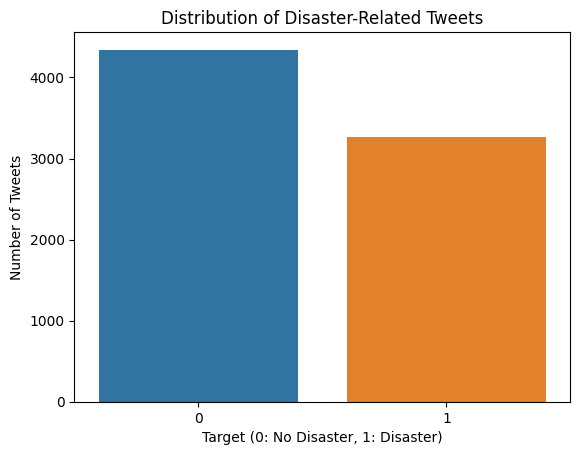

In [9]:
# Distribution of target variables

sns.countplot(x='target', data=train_df)
plt.title('Distribution of Disaster-Related Tweets')
plt.xlabel('Target (0: No Disaster, 1: Disaster)')
plt.ylabel('Number of Tweets')
plt.show()

Using the distribution of the `target` variables, it shows that an average tweet indicates there are no diasters.



## Text Processing

Preprocessing text data is important for several reasons. It is a necessary steps in any natural language processing (NLP) task, as it helps to clean and standadize the text, making it easier for NLP algorithm to process.

In [10]:
# change the text variable format to a lower case
train_df['text'] = train_df['text'].str.lower()

In [11]:
# create a function to remove the punctuation marks
import re

def remove_punctuation(text):
  text = re.sub(r'[^\w\s]', ' ', text)
  return text

train_df['text'] = train_df['text'].apply(remove_punctuation)

In [12]:
train_df.head()

,text,target
0,our deeds are the reason of this earthquake m...,1
1,forest fire near la ronge sask canada,1
2,all residents asked to shelter in place are ...,1
3,13 000 people receive wildfires evacuation or...,1
4,just got sent this photo from ruby alaska as ...,1


In [13]:
X = train_df['text']
y = train_df['target']

In [14]:
from sklearn.model_selection import train_test_split

# split the data into training (80%) and validation sets (20%)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 100)
print(F"X_train: {X_train.shape}, X_val: {X_val.shape}, y_train: {y_train.shape}, y_val: {y_val.shape}")

X_train: (6090,), X_val: (1523,), y_train: (6090,), y_val: (1523,)


# Build a Transformer Model

In [15]:
!pip install transformers

In [16]:
import transformers
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers import AutoTokenizer


In [17]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

print(tokenizer.model_max_length)
print(tokenizer.vocab_size)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

512
30522


In [18]:
train_encoding = tokenizer(list(X_train), truncation=True, padding=True)
val_encoding = tokenizer(list(X_val), truncation=True, padding=True)

In [19]:
# Transforming to tensorflow datasets
# Preparing the data for transformer

train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encoding), tf.constant(y_train.values, dtype=tf.int32)))

val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encoding), tf.constant(y_val.values, dtype=tf.int32)))


# configuring the datasets

train_dataset = train_dataset.batch(16)

val_dataset = val_dataset.batch(16)

In [20]:
# Build and evaluate the model

model = TFAutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels = 2)

# Define optimizer, loss, and metrics 
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]

# Compile the model 

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)


model.fit(train_dataset, epochs=10, verbose = False)

train_loss, train_acc = model.evaluate(train_dataset)
print(F"Train set accuracy: {train_acc}")

val_loss, val_acc = model.evaluate(val_dataset)
print(F"Validation set accuracy: {val_acc}")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


I0000 00:00:1730820427.619444     135 service.cc:145] XLA service 0x7ba35a9d5fc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730820427.619497     135 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1730820427.619502     135 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1730820427.782056     135 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


381/381 [==============================] - 21s 35ms/step - loss: 0.0290 - accuracy: 0.9883
Train set accuracy: 0.9883415699005127
96/96 [==============================] - 3s 36ms/step - loss: 0.9464 - accuracy: 0.8267
Validation set accuracy: 0.8266578912734985


# Concluusion
In this project,built a deep learning classification model using Tensorflow. I used a real world tweets dataset to predict whether a tweet indicated disaster or not.

From the previous notebook of the same project. I started with a shallow neural network and went all the way to build Transformer based models. The performance of these various models are summarized below;

+ **`Shallow Neural Network`**: Training set and Validation set accuracy are 58%
+ **`Multilayer Deep Text Classification Model`**: Training set accuracy 56% and Validation set accuracy of 57%
+ **`Multilayer Bidirectional LSTM Model`**: Training set 95% and Validation set accuracy of 78% 
+ **`Transformer Model`**: Training set accuracy 98% and Validation set accuracy of 82%

The best performance comes from Transformer Model.
